# AOSLO Crowding & Microsaccades:

  This script is used to analyse and plot crowding and microsaccade data and to be able to understand the relationship   between the two.

In [1]:
%pylab inline
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time, sys

Populating the interactive namespace from numpy and matplotlib


In [2]:
# First we import the different dataframes created from the analysis protocols and also the behavioral data
# ..and put in the necessary codes:

#"D:\\KSP\Study\\Houston\\Projects\\TSLOExperiments\\AOData\\AnalysisOutput\\FilteredDataset"
# os.chdir("D:\\KSP\\Study\\Houston\\Projects\\TSLOExperiments\\AOData\\AnalysisOutput")
# data_dir="/home/dcoates/Desktop/krish/tslo_analysis/RotationCorrectionData/"
# os.chdir(data_dir)
eyepos=pd.read_pickle("filteredEyePos.pkl")
stimTimes=pd.read_csv("StimulusDataFiltered.csv")
behavData=pd.read_csv("df_behavioral_per_trial.csv")
saccData=pd.read_csv("microSaccFiltered.csv")
trackingDF=pd.read_pickle("trackingQualitydf.pkl")

# The saccade directions range from -180 to +180 and uses the atan2d function in matlab. So to retrieve values that range between 0 and 360 we add 360 for values that
# are below 0
saccData['DirectionPolar']=saccData['Direction']

# For only the negative ones, add 360:
negs=saccData['DirectionPolar']<0
saccData.loc[negs,'DirectionPolar'] += 360

def row_to_code_behav(x):
    return "%s_%s_%03d"%(x.vidcode,x.subj,x.ntrial+1)

behavData["code"]=(behavData.apply(row_to_code_behav,1)).astype(str)

# The behavioral data and saccade data are merged together
saccDataMerged=pd.merge(saccData,behavData,left_on='code',right_on='code')

#Finally, we correct the rotate issues with the images.For smaller FOV the direction values are to be rotated by 90 (clockwise) and for bigger ones by -90 or counter
# clockwise
smallFov=saccDataMerged.query("fieldsize<2")
bigFov=saccDataMerged.query("fieldsize>2")
            
directionMerge=pd.concat( (bigFov,smallFov))#, right=behavData, on='code' )

# Summarize microsaccade direction into the 4 polar directions (0,90,180,270), taking evertying withing +/-45deg
df1=directionMerge
#directionMerge[df45>DirectionPolar | DirectionPolar>(360-45)' ).count()['DirectionPolar']
directionMerge.loc[np.any( ((45>df1.DirectionPolar), (df1.DirectionPolar>360-45)),axis=0),'direct']=0

for angl in [90,180,270]:
    directionMerge.loc[np.all( ((angl-45<df1.DirectionPolar), (df1.DirectionPolar<angl+45)),axis=0),'direct']=int(angl)

FileNotFoundError: [Errno 2] No such file or directory: 'filteredEyePos.pkl'

In [49]:
# New direction and stimulus codes: horiz or vertical, # of saccades (put into behavioral results), etc.

# Is a saccade direction horizontal? (vs. vertical)
directionMerge['horiz']=np.any( (directionMerge.direct==0,directionMerge.direct==180), 0 )

dfNumSaccades=directionMerge.groupby('code').count()['ntrial'].reset_index()
dfNumSaccades=dfNumSaccades.rename(columns={"ntrial": "nsaccades"})
behav2=pd.merge( behavData,dfNumSaccades, on='code', how='outer') 
behav2.nsaccades=behav2.nsaccades.fillna(value=0)

dfNumSaccades=directionMerge.query('direct==90|direct==270').groupby('code').count()['ntrial'].reset_index()
dfNumSaccades=dfNumSaccades.rename(columns={"ntrial": "numvert"})
behav2=pd.merge( behav2,dfNumSaccades, on='code', how='outer') 
behav2.numvert=behav2.numvert.fillna(value=0)
behav2.loc[:,'vert']=behav2.numvert>0

dfNumSaccades=directionMerge.query('direct==0|direct==180').groupby('code').count()['ntrial'].reset_index()
dfNumSaccades=dfNumSaccades.rename(columns={"ntrial": "numhoriz"})
behav2=pd.merge( behav2,dfNumSaccades, on='code', how='outer') 
behav2.numhoriz=behav2.numhoriz.fillna(value=0)
behav2.loc[:,'horiz']=behav2.numhoriz>0

behav2.loc[:,'stairlate']=(behav2.ntrial>10) # Ignore first few trials of staircase (too big letters) 

behav2.drop(behav2[behav2.barwidths==6].index, inplace = True)  # nuisance

In [50]:
behav2.loc[behav2.stim==0,'correcto']=1*np.any(
    (behav2[behav2.stim==0].resp==0,behav2[behav2.stim==0].resp==180),0)
behav2.loc[behav2.stim==180,'correcto']=1*np.any(
    (behav2[behav2.stim==180].resp==0,behav2[behav2.stim==180].resp==180),0)

behav2.loc[behav2.stim==90,'correcto']=1*np.any(
    (behav2[behav2.stim==90].resp==90,behav2[behav2.stim==90].resp==270),0)
behav2.loc[behav2.stim==270,'correcto']=1*np.any(
    (behav2[behav2.stim==270].resp==90,behav2[behav2.stim==270].resp==270),0)

behav2.correcto=np.array(behav2.correcto, dtype='float')

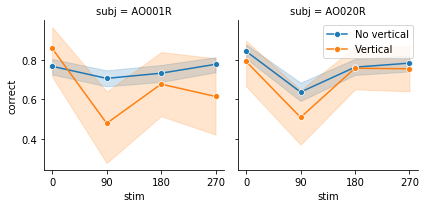

In [51]:
g = sns.FacetGrid(behav2.query('ntrial>10&ecc<2'), col='subj', hue='vert' ) #col="stim", 
g.map(sns.lineplot, "stim", "correct",marker='o');
plt.xticks(dirs);
plt.legend(['No vertical', 'Vertical'],loc='best')

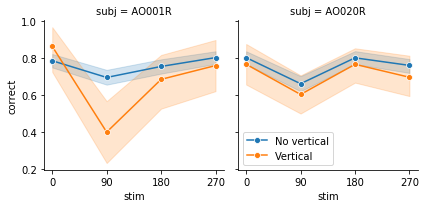

In [52]:
g = sns.FacetGrid(behav2.query('ntrial>15&ecc<=2'), col='subj', hue='vert' ) #col="stim", 
g.map(sns.lineplot, "stim", "correct",marker='o');
plt.xticks(dirs);
plt.legend(['No vertical', 'Vertical'],loc='best')

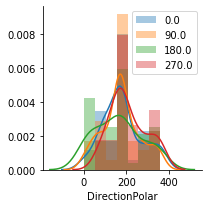

In [53]:
df1=directionMerge.query('ecc==0 & barwidths>=4')
g = sns.FacetGrid(df1, hue='stim') 
g.map(sns.distplot, 'DirectionPolar',bins=np.linspace(0,360,8)) #, hist=False, rug=True);
plt.legend()
plt.savefig('directions.png')

In [54]:
dirs=[0,90,180,270]
subs=["AO001R","AO020R"]

# saccdir_x : is the abscissa saccade direction (if False, it's stimulus direction)
def qpanel(conditions,saccdir_x,baseq=None,onset_before=None,ntrial_after=None):
    
    if baseq is None: # Need something.. "True" doesn't work
        q='ecc>=0' # True for all trials
    else:
        q=baseq
    if not onset_before is None:
        q += '& onsetTime<@onset_before'
    if not ntrial_after is None:
        q += '& ntrial_after<@ntrial_after'
    
    vals2=np.zeros( (len(conditions),len(dirs),4))
    nt=np.zeros( (len(conditions),len(dirs))) # number of trials per condition (or saccade dir.)

    for ncond,cond in enumerate(conditions):
        quer=q+'&'+cond # Base query is the condition string

        for ntarg,targ in enumerate(dirs):
            if saccdir_x:
                quer += '& stim==@targ' # Add direction query

            df1=directionMerge.query(quer)

            if saccdir_x:
                ntrials1=len( behavData.query(quer) ) # normalize #. num sacc in that cond
                res=df1.groupby('direct').count()['Direction'].to_numpy()
            else:
                ntrials1=len( df1 )  # normalize #. num trials in that cond
                res=df1.groupby('stim').count()['Direction'].to_numpy()

            vals2[ncond,ntarg,:]=res
            vals2[ncond,ntarg] /= ntrials1 # normalize
            nt[ncond,ntarg]=ntrials1 # Remember # of trials

    rows=len(conditions)//4+1
    plt.figure(figsize=(15,3*rows))
    for ncond in np.arange(len(conditions)):
        if ncond>0:
            ax=plt.subplot(rows,4,ncond+1,label=ncond,sharex=ax0,sharey=ax0)
        else:
            ax0=plt.subplot(rows,4,ncond+1,label=ncond)
            ax=ax0 # Needed for later for the transAxes

        for nstim in np.arange(len(dirs)):
            plt.plot( vals2[ncond,nstim], label=dirs[nstim], marker='.' )
        plt.text(0.1,0.1, 'N=%d'%nt[ncond,nstim],  transform=ax.transAxes)

        plt.title(conditions[ncond],size=8)
        #plt.ylim(0.0,0.1)
        plt.xticks(range(4), dirs);
        plt.grid()

        if ncond%4==0:
            if saccdir_x:
                plt.xlabel('Microsaccade direction', size=18)
            else:
                plt.xlabel('Stimulus orientation', size=18)

        if ncond==0:
            plt.ylabel('Prop. of trials', size=18)
        #else:
         #   plt.gca().set_yticklabels([])

    if saccdir_x:
        plt.legend(loc='best')
#plt.savefig('microsaccades_all.png')

In [55]:
# These little "queries" are now used as an argument to "qpanel"

q=7

# saccdir_x: Is the x-axis saccade direction? (If False: stimulus orientation)

if q==0:
    conditions=['ecc<1 & barwidths<=3',
            'ecc<1 & barwidths>3',
            '0<ecc<=2 & barwidths<=3',
            '0<ecc<=2 & barwidths>3',
            '2<ecc & barwidths<=3',
            '2<ecc & barwidths>3'
           ]
    saccdir_x=True

elif q==1:
    conditions=['ecc==0 & barwidths<=3',
            'ecc==0 & barwidths>3',
                'ecc>0.5 & barwidths<=3',
            'ecc>0.5 & barwidths>3' ]  
    saccdir_x=True
        
elif q==2:
    conditions=['ecc<0.5',
            'ecc>=0.5', 'ecc>=0' ]
    saccdir_x=True
    
elif q==3:
    conditions=[
        'ecc<0.5 & direct==0',
        'ecc<0.5 & direct==90',
        'ecc<0.5 & direct==180',
        'ecc<0.5 & direct==270',
 
        'ecc==0.5 & direct==0',
        'ecc==0.5 & direct==90',
        'ecc==0.5 & direct==180',
        'ecc==0.5 & direct==270',
        
        'ecc==1 & direct==0',
        'ecc==1 & direct==90',
        'ecc==1 & direct==180',
        'ecc==1 & direct==270',
        
        'ecc==1.5 & direct==0',
        'ecc==1.5 & direct==90',
        'ecc==1.5 & direct==180',
        'ecc==1.5 & direct==270',
        
        'ecc==2 & direct==0',
        'ecc==2 & direct==90',
        'ecc==2 & direct==180',
        'ecc==2 & direct==270' ]
    saccdir_x=False

elif q==4:
    conditions=['ecc>=0' ]; #everything
    saccdir_x=False
    
elif q==5:
    saccdir_x=False
    conditions=[
        'ecc<=0.5 & (direct==0)',
        'ecc<=0.5 & (direct==90)',
        'ecc<=0.5 & (direct==180)',
        'ecc<=0.5 & (direct==270)',
        
        '2>ecc>0.5 & (direct==0)',
        '2>ecc>0.5 & (direct==90)',
        '2>ecc>0.5 & (direct==180)',
        '2>ecc>0.5 & (direct==270)',
        
        '4>ecc>=2 & (direct==0)',
        '4>ecc>=2 & (direct==90)',
        '4>ecc>=2 & (direct==180)',
        '4>ecc>=2 & (direct==270)',
        
        '4<=ecc & (direct==0)',
        '4<=ecc & (direct==90)',
        '4<=ecc & (direct==180)',
        '4<=ecc & (direct==270)',
    ]
    
elif q==6:
    saccdir_x=False
    conditions=[
        'ecc<=0.5 & (direct==0) & barwidths<=3',
        'ecc<=0.5 & (direct==90)& barwidths<=3',
        'ecc<=0.5 & (direct==180)& barwidths<=3',
        'ecc<=0.5 & (direct==270)& barwidths<=3',

        'ecc<=0.5 & (direct==0)& barwidths>3',
        'ecc<=0.5 & (direct==90)& barwidths>3',
        'ecc<=0.5 & (direct==180)& barwidths>3',
        'ecc<=0.5 & (direct==270)& barwidths>3',

    ]

elif q==7:
    saccdir_x=False
    conditions=[
        
        '2>ecc & (direct==0)',
        '2>ecc & (direct==90)',
        '2>ecc & (direct==180)',
        '2>ecc & (direct==270)',
        
        '2<=ecc & (direct==0)',
        '2<=ecc & (direct==90)',
        '2<=ecc & (direct==180)',
        '2<=ecc & (direct==270)',

    ]
    

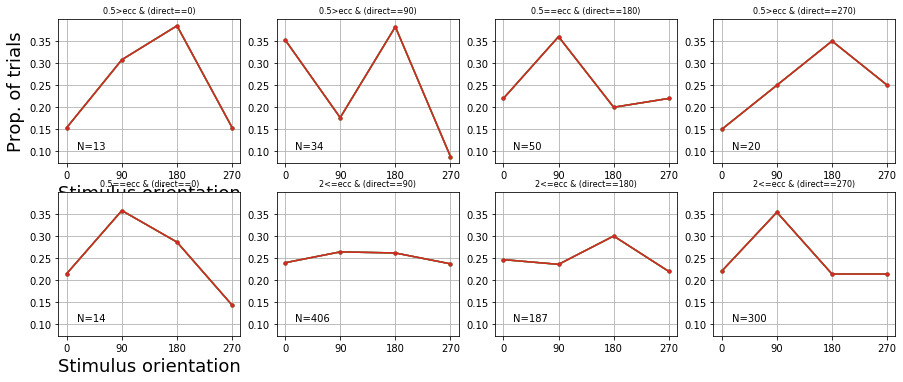

In [56]:
# These shortcuts can be used in query stringts to isolate subject
SUB1='subj=="%s"'%subs[0]
SUB2='subj=="%s"'%subs[1]

qpanel(['0.5>ecc & (direct==0)',
        '1.5>ecc & (direct==90)',
        '1.5>ecc & (direct==180)',
        '1.5>ecc & (direct==270)',
        
        '2<=ecc & (direct==0)',
        '2<=ecc & (direct==90)',
        '2<=ecc & (direct==180)',
        '2<=ecc & (direct==270)'], False, 'subj=="%s"'%subs[0])

qpanel(['0.5>ecc & (direct==0)',
        '0.5>ecc & (direct==90)',
        '0.5==ecc & (direct==180)',
        '0.5>ecc & (direct==270)',
        
        '0.5==ecc & (direct==0)',
        '2<=ecc & (direct==90)',
        '2<=ecc & (direct==180)',
        '2<=ecc & (direct==270)'], False, 'subj=="%s"'%subs[1])

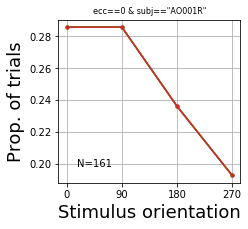

In [57]:
qpanel(['ecc==0 & '+SUB1],False)
qpanel(['ecc==0 & %s'%SUB2],False)

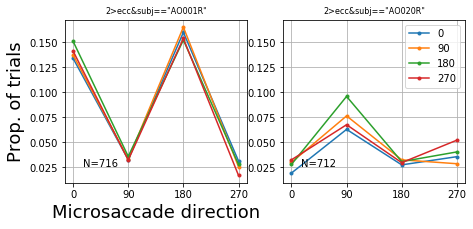

In [58]:
# These shortcuts can be used in query stringts to isolate subject
qpanel(['2>ecc&'+SUB1,
        '2>ecc&'+SUB2],
       True)

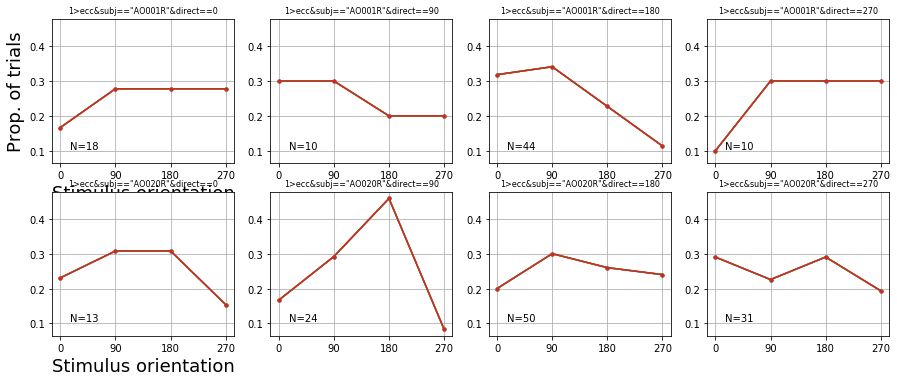

In [60]:
b='1>ecc&'+SUB1+'&direct=='
b2='1>ecc&'+SUB2+'&direct=='

qpanel([b+"0", b+"90", b+"180", b+"270",
        b2+"0", b2+"90", b2+"180", b2+"270"],
       False,onset_before=0.59)
qpanel([b+"0", b+"90", b+"180", b+"270",
        b2+"0", b2+"90", b2+"180", b2+"270"],
       False,onset_before=None)



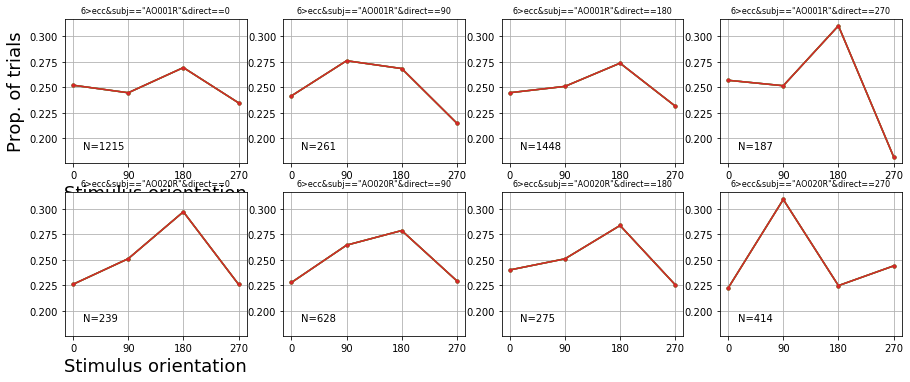

In [61]:
b='6>ecc&'+SUB1+'&direct=='
b2='6>ecc&'+SUB2+'&direct=='
qpanel([b+"0", b+"90", b+"180", b+"270",
        b2+"0", b2+"90", b2+"180", b2+"270"],
       False,onset_before=None)

In [62]:
len( directionMerge ), 649+106+2014+342+124+285+390+757

(4667, 4667)

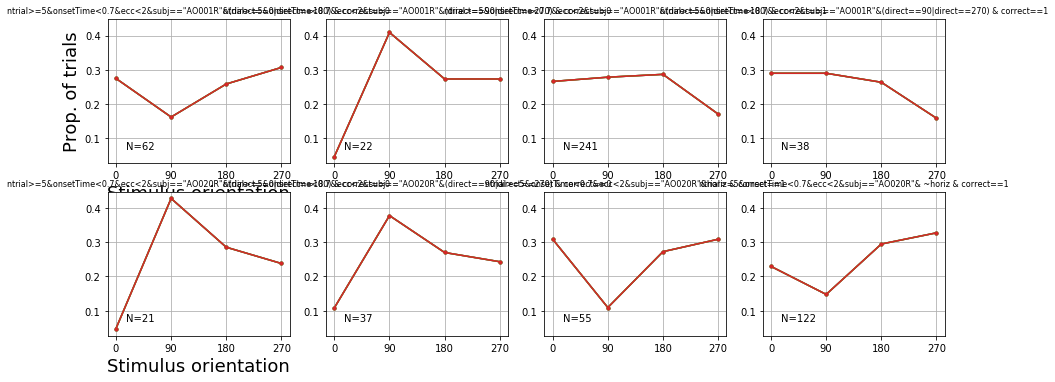

In [63]:
b= 'ntrial>=5&onsetTime<0.7&ecc<2&' +SUB1
b2='ntrial>=5&onsetTime<0.7&ecc<2&' +SUB2
qpanel([b+"&(direct==0|direct==180) & correct==0", b+"&(direct==90|direct==270) & correct==0",
       b+"&(direct==0|direct==180) & correct==1",  b+"&(direct==90|direct==270) & correct==1",
       b2+"&(direct==0|direct==180) & correct==0", b2+"&(direct==90|direct==270) & correct==0",
       b2+"&horiz & correct==1", b2+"& ~horiz & correct==1"],False)


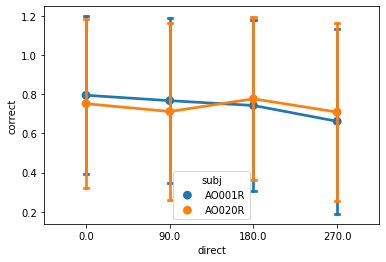

In [188]:
df1=directionMerge.query("ntrial>15")
sns.pointplot(x='direct',y='correct',ci='sd',hue='subj',data=df1,capsize=0.05)

In [195]:
base1=behav2.query("nsaccades==0 & ntrial>15 & subj=='AO001R'").mean()['correct']
base2=behav2.query("nsaccades==0 & ntrial>15 & subj=='AO020R'").mean()['correct']
perf2=directionMerge.query("ntrial>15 & subj=='AO020R'").groupby('direct').mean()['correct']
plt.plot(perf1/base1,label='AO001R',marker='o',color='C0')
plt.plot(perf2/base2,label='AO020R',marker='o',color='C1')
plt.plot([0,270],[1,1], 'k--',label='No Microsaccade')
plt.legend(loc='best')
yl="$\Delta$ Prop. correct\n"
yl+="(Last 15 Trials)"
plt.ylabel(yl,size=12)
plt.xlabel("Microsaccade Direction (degrees)",size=12)
plt.tight_layout()
# plt.savefig('performanceVsaccadeDir.pdf',bbox_tight=True)

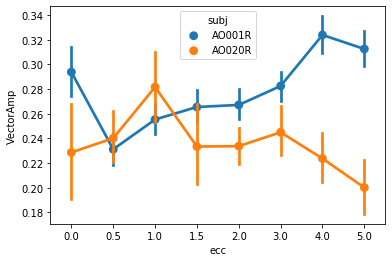

In [209]:
df1=saccDataMerged.query("barwidths!=6.0")
sns.pointplot(x='ecc',y='VectorAmp',hue='subj',data=df1)

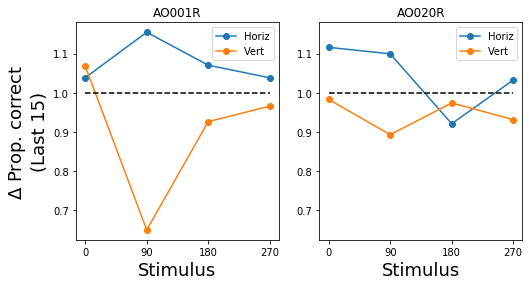

In [174]:
plt.figure(figsize=(8,4))
trial1=15
ax0=None
for gt in [1]:
  for s in [0,1]:
    ax=plt.subplot(1,2,s+1+gt*0,sharex=ax0,sharey=ax0)
    if s*gt==0:
        ax0=ax
        
    if gt==0:
        baseq='ecc<=2&ntrial<%d&subj==@subs[%d]'%(trial1,s)
    else:
        baseq='ecc<=2&ntrial>=%d&subj==@subs[%d]'%(trial1,s)
        
    base=behav2.query(baseq).groupby('stim').mean()['correct'] #, label='All',color='k' )
    perf_h=behav2.query(baseq+'& numhoriz>0').groupby('stim').mean()['correct']
    plt.plot( perf_h/base, label='Horiz', marker='o' )
    perf_v=behav2.query(baseq+'& numvert>0').groupby('stim').mean()['correct']
    plt.plot( perf_v/base, label='Vert', marker='o' )
    plt.legend(loc='best')
    
    count_h=behav2.query(baseq+'& horiz').groupby('stim').count()['correct']
    count_v=behav2.query(baseq+'& vert').groupby('stim').count()['correct']
    
    plt.plot([0,270],[1,1], 'k--')
    plt.xticks(dirs);
 
    plt.xlabel("Stimulus",size=18)
    if s==0:
        yl="$\Delta$ Prop. correct\n"
        yl += "(First %d)"%trial1 if gt==0 else "(Last %d)"%trial1
        plt.ylabel(yl,size=18)
        
    plt.title(subs[s])
    
plt.savefig('performance_vs_direction.pdf',bbox_tight=True)

In [65]:
count_h,perf_h

(stim
 0.0      37
 90.0     36
 180.0    41
 270.0    31
 Name: correct, dtype: int64,
 stim
 0.0      0.891892
 90.0     0.722222
 180.0    0.731707
 270.0    0.774194
 Name: correct, dtype: float64)

In [66]:
count_v,perf_v

(stim
 0.0      70
 90.0     75
 180.0    84
 270.0    73
 Name: correct, dtype: int64,
 stim
 0.0      0.785714
 90.0     0.586667
 180.0    0.773810
 270.0    0.698630
 Name: correct, dtype: float64)

In [67]:
baseq

'ecc<=2&ntrial>=15&subj==@subs[1]'

In [68]:
print( np.mean( behav2.query(baseq+'& stim==90').correct ) )
print( len( behav2.query(baseq+'& stim==270').correct ) )

0.6570048309178744
588


In [69]:
bits=behav2.query(baseq+'& stim==270').correct.to_numpy()

In [70]:
flips=[np.mean( bits[np.random.permutation(np.arange(588))[0:73]] ) for n in np.arange(1000)]

In [71]:
val=0.698
np.where(val<np.sort(flips))[0][0]/1000.0

0.103

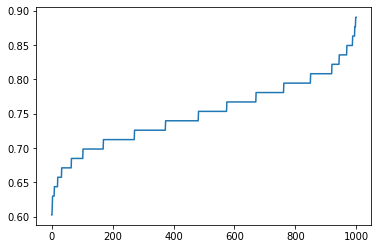

In [72]:
plt.plot( np.sort(flips) )

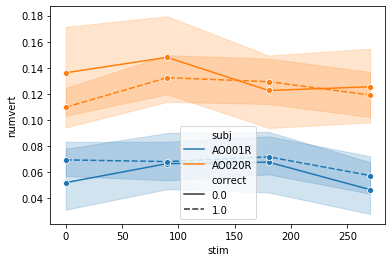

In [73]:
sns.lineplot("stim", "numvert",marker='o',hue='subj',data=behav2, style='correct')

(0, 0.1)

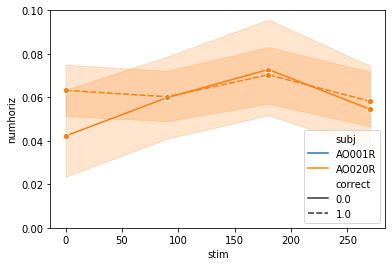

In [74]:
sns.lineplot("stim", "numhoriz",marker='o',hue='subj',data=behav2, style='correct')
plt.ylim(0,0.1)

([<matplotlib.axis.XTick at 0x223b2bc5550>,
 <a list of 4 Text xticklabel objects>)

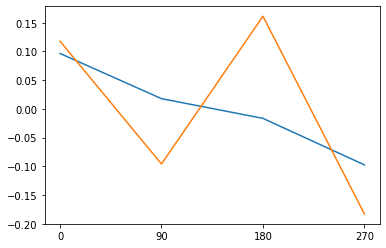

In [75]:
bq=directionMerge.query('ntrial>5&ecc<1&horiz&correct==1&'+SUB2)
numcor=bq.groupby('stim').count()['ntrial']
bq=directionMerge.query('ntrial>5&ecc<1&horiz&correct==0&'+SUB2)
numincor=bq.groupby('stim').count()['ntrial']
plt.plot(numcor/np.sum(numcor)-numincor/np.sum(numincor)); xticks(dirs)

bq=directionMerge.query('ntrial>5&ecc<1&~horiz&correct==1&'+SUB2)
numcor=bq.groupby('stim').count()['ntrial']
bq=directionMerge.query('ntrial>5&ecc<1&~horiz&correct==0&'+SUB2)
numincor=bq.groupby('stim').count()['ntrial']
plt.plot(numcor/np.sum(numcor)-numincor/np.sum(numincor))
plt.grid()

s=SUB1
plt.figure()
bq=directionMerge.query('ntrial>5&ecc<1&horiz&correct==1&'+s)
numcor=bq.groupby('stim').count()['ntrial']
bq=directionMerge.query('ntrial>5&ecc<1&horiz&correct==0&'+s)
numincor=bq.groupby('stim').count()['ntrial']
plt.plot(numcor/np.sum(numcor)-numincor/np.sum(numincor)); xticks(dirs)

bq=directionMerge.query('ntrial>5&ecc<1&~horiz&correct==1&'+s)
numcor=bq.groupby('stim').count()['ntrial']
bq=directionMerge.query('ntrial>5&ecc<1&~horiz&correct==0&'+s)
numincor=bq.groupby('stim').count()['ntrial']
plt.plot(numcor/np.sum(numcor)-numincor/np.sum(numincor)); xticks(dirs)

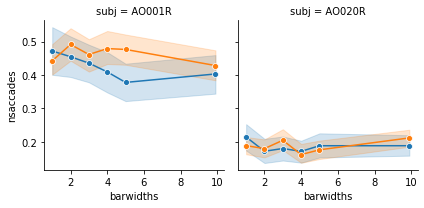

In [76]:
g = sns.FacetGrid(behav2, col='subj', hue='stairlate' ) #col="stim", 
g.map(sns.lineplot, "barwidths", "nsaccades",marker='o');

#g = sns.barplot(x="barwidths", y="nsaccades",data=behav2 )#,style='numhoriz')

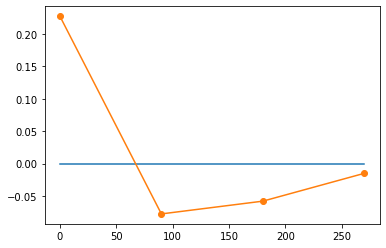

In [77]:
dfH=directionMerge.query('ntrial>5&ecc<1&'+SUB1)
cH=dfH.groupby('stim').mean()['correct'] #.to_numpy()
dfV=directionMerge.query('ntrial>5&ecc<1&'+SUB1)
cDiff=cH-dfV.groupby('stim').mean()['correct'].to_numpy()

plt.plot(cDiff)

dfH=directionMerge.query('ntrial>5&ecc<1&horiz&'+SUB2)
cH=dfH.groupby('stim').mean()['correct'] #.to_numpy()
dfV=directionMerge.query('ntrial>5&ecc<1&~horiz&'+SUB2)
cDiff=cH-dfV.groupby('stim').mean()['correct'].to_numpy()
plt.plot(cDiff, 'o-')

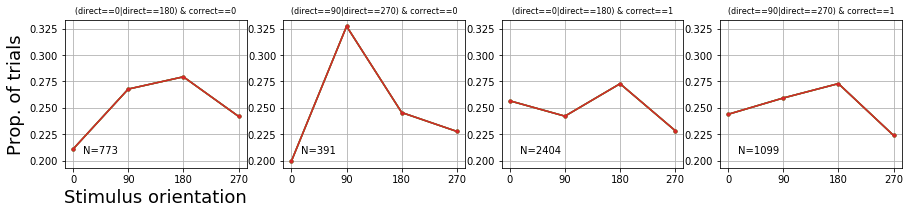

In [78]:
qpanel(["(direct==0|direct==180) & correct==0", "(direct==90|direct==270) & correct==0",
        "(direct==0|direct==180) & correct==1", "(direct==90|direct==270) & correct==1"],False)


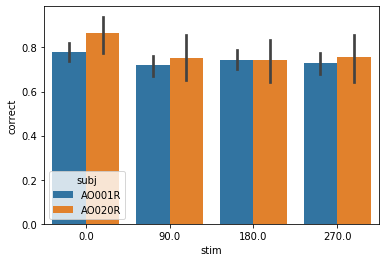

In [79]:
df1=directionMerge.query('direct==180')
sns.barplot( x='stim', y='correct', data=df1, hue='subj')

C:\Users\krish\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


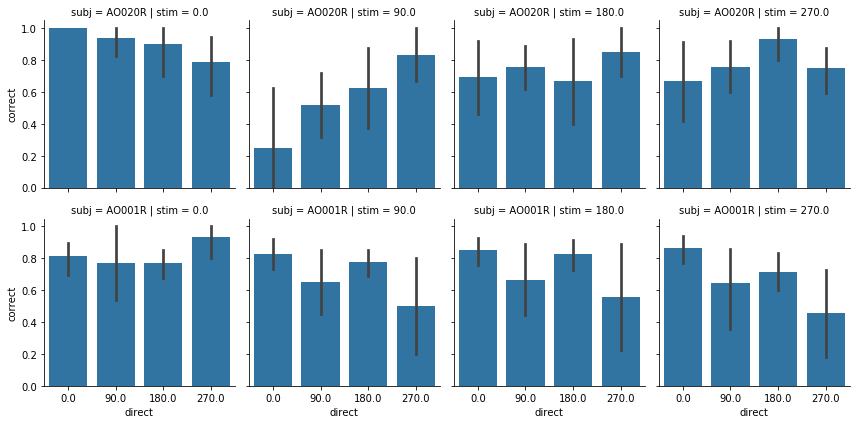

In [80]:
df1=directionMerge.query('(ecc<2) & (ntrial>=0) & (onsetTime<0.8) & (barwidths>=2)')
g = sns.FacetGrid(df1, col="stim", row='subj' )#, height=4, aspect=.5) #, row='subj'
g.map(sns.barplot, "direct", "correct");

In [81]:
directionMerge.query('(ecc<2) & (ntrial>=0) & (onsetTime<0.5) & (barwidths>=0) & (stim==90)').groupby('direct').count()

Unnamed: 0_x  Duration  onsetIdx  offsetIdx  onsetTime  offsetTime  \
direct                                                                       
0.0                7         7         7          7          7           7   
90.0               5         5         5          5          5           5   
180.0             22        22        22         22         22          22   
270.0             10        10        10         10         10          10   

        xAmp  yAmp  VectorAmp  Direction  ...  size_min  size_deg  ee_min  \
direct                                    ...                               
0.0        7     7          7          7  ...         7         7       7   
90.0       5     5          5          5  ...         5         5       5   
180.0     22    22         22         22  ...        22        22      22   
270.0     10    10         10         10  ...        10        10      10   

        cc_min  cc_deg  vidcode  ntrial  size_real  spac_real  horiz  
direct                                                                
0.0          7       7        7       7          7          7      7  
90.0         5       5        5       5          5          5      5  
180.0       22      22       22      22         22         22     22  
270.0       10      10       10      10         10         10     10  

[4 rows x 44 columns]

In [82]:
df1=directionMerge.query('(ntrial>=0) & (onsetTime<0.5)')
g = sns.FacetGrid(df1, col="stim", row='subj' )#, height=4, aspect=.5) #, row='subj'
g.map(sns.barplot, "direct", "correct");

C:\Users\krish\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [83]:
df1=directionMerge.query('ntrial>20&onsetTime<0.8')
sns.barplot( x='ecc', y='barwidths', data=df1, hue='subj')